In [2]:
import numpy as np 
import pandas as pd 

import re
import nltk
# nltk.download('all')
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from lightgbm import LGBMClassifier

import tensorflow as tf
from keras import backend as K
from keras.layers.convolutional import Conv1D
from keras.layers import TextVectorization, Dense, Embedding, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.models import Sequential
from keras.models import Sequential
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

%matplotlib inline


## Data Prep

In [3]:
# Unzip files in Data_Files folder first
root_path = '../Data_Files/'
data = pd.read_csv(root_path + "hotels_reviews.csv")
print(data['reviews.clean_text'].isna().any())
data.head()
data.columns

True


Index(['id', 'dateAdded', 'dateUpdated', 'address', 'categories',
       'primaryCategories', 'city', 'country', 'keys', 'latitude', 'longitude',
       'name', 'postalCode', 'province', 'reviews.date', 'reviews.dateSeen',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username',
       'sourceURLs', 'websites', 'language', 'reviews.clean_text',
       'userCity_upper', 'userProvince_upper', 'is_state', 'user_country',
       'ratingCategory'],
      dtype='object')

## Word Freq

In [32]:
goodText = data.query("`ratingCategory` == 2")["reviews.clean_text"]
neutralText = data.query("`ratingCategory` == 1")["reviews.clean_text"]
badText = data.query("`ratingCategory` == 0")["reviews.clean_text"]

In [33]:
words: list[str] = nltk.word_tokenize(' '.join(goodText))
fd = nltk.FreqDist(words)
goodWordsTuple = fd.most_common(75)
goodWords = set([tupler[0] for tupler in goodWordsTuple])

words: list[str] = nltk.word_tokenize(' '.join(neutralText))
fd = nltk.FreqDist(words)
neutralWordsTuple = fd.most_common(75)
neutralWords = set([tupler[0] for tupler in neutralWordsTuple])

words: list[str] = nltk.word_tokenize(' '.join(badText))
fd = nltk.FreqDist(words)
badWordsTuple = fd.most_common(75)
badWords = set([tupler[0] for tupler in badWordsTuple])

repeatedWords = goodWords.intersection(neutralWords).intersection(badWords)
goodWords.difference_update(repeatedWords)
neutralWords.difference_update(repeatedWords)
badWords.difference_update(repeatedWords)

print(len(repeatedWords))
print(goodWords)
print(neutralWords)
print(badWords)

# fd.tabulate(3) # in table form yo

43
{'much', 'enjoy', 'close', 'happy', 'definitely', 'perfect', 'feel', 'walk', 'pool', 'inn', 'love', 'friendly', 'new', 'family', 'everything', 'visit', 'free', 'excellent', 'comfortable', 'helpful', 'parking', 'always', 'right', 'restaurant', 'trip', 'food', 'hope', 'really', 'wonderful', 'welcome', 'view', 'recommend'}
{'much', 'enjoy', 'floor', 'close', 'two', 'work', 'feel', 'hear', 'walk', 'pool', 'price', 'friendly', 'lot', 'new', 'visit', 'free', 'comfortable', 'helpful', 'old', 'parking', 'right', '2', 'street', 'restaurant', 'hope', 'really', 'small', 'little', 'bathroom', 'give', 'use', 'door'}
{'smell', 'floor', 'two', 'try', 'work', 'want', 'another', 'people', 'water', 'first', 'say', 'dirty', 'old', 'call', '2', 'bad', 'charge', 'never', 'shower', 'small', 'ask', 'pay', 'bathroom', 'manager', 'tell', 'book', 'leave', 'know', 'give', 'even', 'use', 'door'}


In [34]:
def commonPositiveCount(text):
  texty = text.split(" ")
  return len([word for word in texty if word in goodWords])

def commonNeutralCount(text):
  texty = text.split(" ")
  return len([word for word in texty if word in neutralWords])

def commonNegativeCount(text):
  texty = text.split(" ")
  return len([word for word in texty if word in badWords])

In [35]:
data["commonPositiveCount"] = data['reviews.clean_text'].apply(commonPositiveCount)
data["commonNeutralCount"] = data['reviews.clean_text'].apply(commonNeutralCount)
data["commonNegativeCount"] = data['reviews.clean_text'].apply(commonNegativeCount)

In [36]:
data["ratingCategory"] = data["ratingCategory"].astype("category")

# Sentiment Predictions

## Prebuilt Sentiment Analysis (VADER)

In [37]:
sia = SentimentIntensityAnalyzer()
negValueList = []
neuValueList = []
posValueList = []
compoundValueList = []

for description in data["reviews.clean_text"]:
    result = sia.polarity_scores(description)
    negValueList.append(result["neg"])
    neuValueList.append(result["neu"])
    posValueList.append(result["pos"])
    compoundValueList.append(result["compound"])

data["negValueVADER"] = negValueList
data["neuValueVADER"] = neuValueList
data["posValueVADER"] = posValueList
data["compoundValueVADER"] = compoundValueList

## Split for training, validation, and testing

In [38]:
train, others = train_test_split(data, test_size=0.2, random_state=4222)
validation, test = train_test_split(others, test_size=0.5, random_state=4222)
del(others)

X_train = np.ravel(train[["reviews.clean_text"]])
Y_train = np.ravel(train[["ratingCategory"]])
X_validation = np.ravel(validation[["reviews.clean_text"]])
Y_validation = np.ravel(validation[["ratingCategory"]])
X_test = np.ravel(test[["reviews.clean_text"]])
Y_test = np.ravel(test[["ratingCategory"]])

## TF-IDF & Multinomial Bayes

### without GridSearch

In [39]:
my_tags = ['Negative','Neutral','Positive']
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('mnb', MultinomialNB()),
              ])

nb.fit(X_train, Y_train)

y_pred = nb.predict(X_validation)

print('accuracy %s' % accuracy_score(y_pred, Y_validation))
print(classification_report(Y_validation, y_pred, target_names=my_tags))

accuracy 0.6345177664974619
              precision    recall  f1-score   support

    Negative       1.00      0.04      0.08       228
     Neutral       0.57      0.50      0.53       785
    Positive       0.67      0.88      0.76       957

    accuracy                           0.63      1970
   macro avg       0.75      0.48      0.46      1970
weighted avg       0.67      0.63      0.59      1970



### with GridSearch

In [41]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('mnb', MultinomialNB()),
              ])

# Configure grid search CV
param_grid = {
    "mnb__alpha" : [1, 2, 4, 8]
}
search = GridSearchCV(nb, param_grid, cv=5, scoring="roc_auc_ovr", n_jobs=-1)
search.fit(X_train, Y_train)
y_pred = search.predict(X_validation)

print(search.best_params_)
print('accuracy %s' % accuracy_score(y_pred, Y_validation))
print(classification_report(Y_validation, y_pred, target_names=my_tags))

{'mnb__alpha': 1}
accuracy 0.6345177664974619
              precision    recall  f1-score   support

    Negative       1.00      0.04      0.08       228
     Neutral       0.57      0.50      0.53       785
    Positive       0.67      0.88      0.76       957

    accuracy                           0.63      1970
   macro avg       0.75      0.48      0.46      1970
weighted avg       0.67      0.63      0.59      1970



### predict Data

In [40]:
test["naiveBayesPrediction"] = nb.predict(X_test)

## Linear SVM

### without GridSearch

In [42]:
svm = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=4222, max_iter=5, tol=None)),
               ])
svm.fit(X_train, Y_train)

y_pred = svm.predict(X_validation)

print('accuracy %s' % accuracy_score(y_pred, Y_validation))
print(classification_report(Y_validation, y_pred, target_names=my_tags))

accuracy 0.6624365482233503
              precision    recall  f1-score   support

    Negative       0.84      0.36      0.50       228
     Neutral       0.68      0.43      0.53       785
    Positive       0.64      0.93      0.76       957

    accuracy                           0.66      1970
   macro avg       0.72      0.57      0.60      1970
weighted avg       0.68      0.66      0.64      1970



### with GridSearch

In [43]:
svm = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('svm', SGDClassifier(loss='hinge', penalty='l2', random_state=4222, max_iter=5, tol=None)),
              ])

# Configure grid search CV
param_grid = {
    "svm__alpha" : [0.0001, 0.001, 0.01, 0.1, 1, 2]
}
search = GridSearchCV(svm, param_grid, cv=5, scoring="roc_auc_ovr", n_jobs=-1)
search.fit(X_train, Y_train)
y_pred = search.predict(X_validation)

print(search.best_params_)
print('accuracy %s' % accuracy_score(y_pred, Y_validation))
print(classification_report(Y_validation, y_pred, target_names=my_tags))

c:\Users\User\miniconda3\envs\bt4222env\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


{'svm__alpha': 0.0001}
accuracy 0.7035532994923858
              precision    recall  f1-score   support

    Negative       0.76      0.57      0.65       228
     Neutral       0.66      0.60      0.63       785
    Positive       0.72      0.82      0.77       957

    accuracy                           0.70      1970
   macro avg       0.71      0.66      0.68      1970
weighted avg       0.70      0.70      0.70      1970



### predict Data

In [41]:
svmF = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('svm', SGDClassifier(loss='hinge', penalty='l2',alpha=0.0001, random_state=4222, max_iter=5, tol=None)),
               ])
svmF.fit(X_train, Y_train)

test["svmPrediction"] = svmF.predict(X_test)

## Logistic Regression

### without GridSearch

In [42]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('lr', LogisticRegression()),
               ])
logreg.fit(X_train, Y_train)

y_pred = logreg.predict(X_validation)

print('accuracy %s' % accuracy_score(y_pred, Y_validation))
print(classification_report(Y_validation, y_pred, target_names=my_tags))

accuracy 0.7045685279187818
              precision    recall  f1-score   support

    Negative       0.78      0.59      0.67       228
     Neutral       0.65      0.63      0.64       785
    Positive       0.73      0.79      0.76       957

    accuracy                           0.70      1970
   macro avg       0.72      0.67      0.69      1970
weighted avg       0.71      0.70      0.70      1970



c:\Users\User\miniconda3\envs\bt4222env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### with GridSearch

In [45]:
logreg = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('lr', LogisticRegression()),
              ])

# Configure grid search CV
param_grid = {
    "lr__C" : [0.1, 1, 2, 4, 8],
    "lr__class_weight": ["balanced", None]
}
search = GridSearchCV(logreg, param_grid, cv=5, scoring="roc_auc_ovr", n_jobs=-1)
search.fit(X_train, Y_train)
y_pred = search.predict(X_validation)

print(search.best_params_)
print('accuracy %s' % accuracy_score(y_pred, Y_validation))
print(classification_report(Y_validation, y_pred, target_names=my_tags))

{'lr__C': 1, 'lr__class_weight': None}
accuracy 0.7045685279187818
              precision    recall  f1-score   support

    Negative       0.78      0.59      0.67       228
     Neutral       0.65      0.63      0.64       785
    Positive       0.73      0.79      0.76       957

    accuracy                           0.70      1970
   macro avg       0.72      0.67      0.69      1970
weighted avg       0.71      0.70      0.70      1970



c:\Users\User\miniconda3\envs\bt4222env\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### predict Data

In [43]:
test["logregPrediction"] = logreg.predict(X_test)

## LGBM

### without GridSearch

In [44]:
lgbm = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('lgbm', LGBMClassifier(objective="multiclass")),
               ])
lgbm.fit(X_train, Y_train)

y_pred = lgbm.predict(X_validation)

print('accuracy %s' % accuracy_score(y_pred, Y_validation))
print(classification_report(Y_validation, y_pred, target_names=my_tags))

accuracy 0.7076142131979696
              precision    recall  f1-score   support

    Negative       0.73      0.62      0.67       228
     Neutral       0.66      0.61      0.64       785
    Positive       0.73      0.81      0.77       957

    accuracy                           0.71      1970
   macro avg       0.71      0.68      0.69      1970
weighted avg       0.71      0.71      0.70      1970



### with GridSearch

In [47]:
lgbm = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('lgbm', LGBMClassifier(objective="multiclass")),
               ])

# Configure grid search CV
param_grid = {
    "lgbm__num_leaves" : [30, 40, 50],
    "lgbm__n_estimators" : [100, 200, 300]
}
search = GridSearchCV(lgbm, param_grid, cv=5, scoring="roc_auc_ovr", n_jobs=-1)
search.fit(X_train, Y_train)
y_pred = search.predict(X_validation)

print(search.best_params_)
print('accuracy %s' % accuracy_score(y_pred, Y_validation))
print(classification_report(Y_validation, y_pred, target_names=my_tags))

{'lgbm__n_estimators': 100, 'lgbm__num_leaves': 30}
accuracy 0.7060913705583757
              precision    recall  f1-score   support

    Negative       0.74      0.62      0.67       228
     Neutral       0.66      0.61      0.64       785
    Positive       0.73      0.80      0.77       957

    accuracy                           0.71      1970
   macro avg       0.71      0.68      0.69      1970
weighted avg       0.70      0.71      0.70      1970



### predict Data

In [45]:
test["lgbmPrediction"] = lgbm.predict(X_test)

## Adaboost

### without GridSearch

In [48]:
ada = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('ada', AdaBoostClassifier(random_state=4222)),
               ])
ada.fit(X_train, Y_train)

y_pred = ada.predict(X_validation)

print('accuracy %s' % accuracy_score(y_pred, Y_validation))
print(classification_report(Y_validation, y_pred, target_names=my_tags))

accuracy 0.615736040609137
              precision    recall  f1-score   support

    Negative       0.59      0.58      0.59       228
     Neutral       0.56      0.47      0.51       785
    Positive       0.65      0.75      0.69       957

    accuracy                           0.62      1970
   macro avg       0.60      0.60      0.60      1970
weighted avg       0.61      0.62      0.61      1970



### with GridSearch

In [49]:
ada = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('ada', AdaBoostClassifier(random_state=4222)),
              ])

# Configure grid search CV
param_grid = {
    "ada__learning_rate" : [0.1, 0.5, 1, 2, 4],
    "ada__n_estimators": [50, 100, 200, 400]
}
search = GridSearchCV(ada, param_grid, cv=5, scoring="roc_auc_ovr", n_jobs=-1)
search.fit(X_train, Y_train)
y_pred = search.predict(X_validation)

print(search.best_params_)
print('accuracy %s' % accuracy_score(y_pred, Y_validation))
print(classification_report(Y_validation, y_pred, target_names=my_tags))

{'ada__learning_rate': 0.5, 'ada__n_estimators': 100}
accuracy 0.6426395939086295
              precision    recall  f1-score   support

    Negative       0.69      0.42      0.52       228
     Neutral       0.56      0.61      0.58       785
    Positive       0.71      0.73      0.72       957

    accuracy                           0.64      1970
   macro avg       0.65      0.58      0.61      1970
weighted avg       0.65      0.64      0.64      1970



### predict Data

In [46]:
adaF = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('ada', AdaBoostClassifier(learning_rate=0.5, n_estimators=100,random_state=4222)),
               ])
adaF.fit(X_train, Y_train)

test["adaboostPrediction"] = adaF.predict(X_test)

## Gradient Boosting

### without GridSearch

In [50]:
gb = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('gb', GradientBoostingClassifier(random_state=4222)),
               ])
gb.fit(X_train, Y_train)

y_pred = gb.predict(X_validation)

print('accuracy %s' % accuracy_score(y_pred, Y_validation))
print(classification_report(Y_validation, y_pred, target_names=my_tags))

accuracy 0.6720812182741117
              precision    recall  f1-score   support

    Negative       0.76      0.40      0.52       228
     Neutral       0.62      0.57      0.60       785
    Positive       0.69      0.82      0.75       957

    accuracy                           0.67      1970
   macro avg       0.69      0.60      0.62      1970
weighted avg       0.67      0.67      0.66      1970



### with GridSearch

In [51]:
gb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('gb', GradientBoostingClassifier(random_state=4222)),
              ])

# Configure grid search CV
param_grid = {
    "gb__learning_rate" : [0.1, 0.5, 1, 2, 4],
    "gb__n_estimators": [50, 100, 200, 400]
}
search = GridSearchCV(gb, param_grid, cv=5, scoring="roc_auc_ovr", n_jobs=-1)
search.fit(X_train, Y_train)
y_pred = search.predict(X_validation)

print(search.best_params_)
print('accuracy %s' % accuracy_score(y_pred, Y_validation))
print(classification_report(Y_validation, y_pred, target_names=my_tags))

{'gb__learning_rate': 0.1, 'gb__n_estimators': 400}
accuracy 0.6883248730964467
              precision    recall  f1-score   support

    Negative       0.76      0.47      0.58       228
     Neutral       0.63      0.61      0.62       785
    Positive       0.72      0.80      0.76       957

    accuracy                           0.69      1970
   macro avg       0.70      0.63      0.65      1970
weighted avg       0.69      0.69      0.68      1970



### predict Data

In [47]:
gbF = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('gb', GradientBoostingClassifier(learning_rate=0.1, n_estimators=400 ,random_state=4222)),
               ])
gbF.fit(X_train, Y_train)

test["gradboostPrediction"] = gbF.predict(X_test)

## Neural Network

### TextVectorization to Preprocess

In [49]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    f1 = history.history['f1']
    val_f1 = history.history['val_f1']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(x, f1, 'b', label='Training f1')
    plt.plot(x, val_f1, 'r', label='Validation f1')
    plt.title('Training and validation f1')
    plt.legend()

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [50]:
vectorize_layer = TextVectorization(output_mode='int')
vectorize_layer.adapt(X_train)
vocabLengthTV = vectorize_layer.vocabulary_size()
print(vocabLengthTV)

22381


In [51]:
XY_train = tf.data.Dataset.from_tensor_slices(
    (tf.constant(vectorize_layer(tf.expand_dims(X_train, -1))), tf.keras.utils.to_categorical(Y_train))
    ).batch(32)
XY_validation = tf.data.Dataset.from_tensor_slices(
    (tf.constant(vectorize_layer(tf.expand_dims(X_validation, -1))), tf.keras.utils.to_categorical(Y_validation))
    ).batch(32)
X_test = tf.data.Dataset.from_tensor_slices(
    (tf.constant(vectorize_layer(tf.expand_dims(X_test, -1))))
    ).batch(32)

XY_train = XY_train.cache().prefetch(buffer_size=10)
XY_validation = XY_validation.cache().prefetch(buffer_size=10)

#### CNN

In [52]:
modelCNN = Sequential()
modelCNN.add(Embedding(vocabLengthTV, 64))
modelCNN.add(Dropout(0.5))

modelCNN.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
modelCNN.add(GlobalMaxPooling1D())

modelCNN.add(Dense(16, activation="relu"))
modelCNN.add(Dropout(0.5))
modelCNN.add(Dense(3, activation="softmax"))

modelCNN.compile(loss="categorical_crossentropy", optimizer= "adam", metrics=['accuracy', f1])
modelCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1432384   
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 conv1d (Conv1D)             (None, None, 64)          12352     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                        

Epoch 1/15
493/493 [==============================] - 26s 51ms/step - loss: 0.9580 - accuracy: 0.5041 - f1: 0.2991 - val_loss: 0.7761 - val_accuracy: 0.6188 - val_f1: 0.5338
Epoch 2/15
493/493 [==============================] - 26s 52ms/step - loss: 0.7612 - accuracy: 0.6356 - f1: 0.5887 - val_loss: 0.6846 - val_accuracy: 0.6695 - val_f1: 0.6510
Epoch 3/15
493/493 [==============================] - 25s 50ms/step - loss: 0.6910 - accuracy: 0.6793 - f1: 0.6567 - val_loss: 0.6617 - val_accuracy: 0.6827 - val_f1: 0.6634
Epoch 4/15
493/493 [==============================] - 25s 50ms/step - loss: 0.6344 - accuracy: 0.7180 - f1: 0.7026 - val_loss: 0.6590 - val_accuracy: 0.6878 - val_f1: 0.6778
Epoch 5/15
493/493 [==============================] - 25s 50ms/step - loss: 0.5816 - accuracy: 0.7487 - f1: 0.7383 - val_loss: 0.6712 - val_accuracy: 0.6919 - val_f1: 0.6897
Epoch 6/15
493/493 [==============================] - 25s 51ms/step - loss: 0.5371 - accuracy: 0.7795 - f1: 0.7691 - val_loss: 0.7

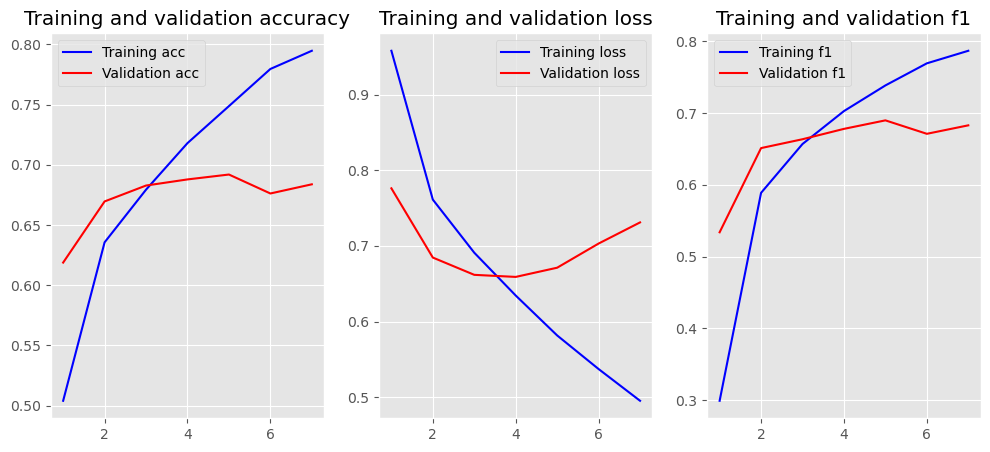

In [53]:
es = EarlyStopping(monitor='val_f1', mode='max', verbose=1, patience=2)

historyCNN = modelCNN.fit(XY_train,
          batch_size=32,
          epochs=15,
          verbose=1,
          validation_data=(XY_validation),
          callbacks=[es])

score, accuracy, f1Score = modelCNN.evaluate(XY_validation, batch_size=32, verbose=2)

plot_history(historyCNN)

In [54]:
mCNNpreds = modelCNN.predict(X_test)
test["cnnPrediction"] = np.argmax(mCNNpreds, axis=-1)

62/62 [==============================] - 0s 3ms/step


#### GlobalAveragePool (sigmoid)

In [55]:
model3 = Sequential()
model3.add(Embedding(vocabLengthTV, 128))
model3.add(GlobalAveragePooling1D())
model3.add(Dense(128, activation='sigmoid'))
model3.add(Dropout(0.2))
model3.add(Dense(3, activation='softmax'))

model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1])

print(model3.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         2864768   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,881,667
Trainable params: 2,881,667
Non-trainable params: 0
____________________________________________

Epoch 1/25
493/493 [==============================] - 15s 29ms/step - loss: 1.0000 - accuracy: 0.4617 - f1: 0.3484 - val_loss: 0.9590 - val_accuracy: 0.4888 - val_f1: 0.0000e+00
Epoch 2/25
493/493 [==============================] - 14s 28ms/step - loss: 0.9695 - accuracy: 0.4827 - f1: 0.3482 - val_loss: 0.9013 - val_accuracy: 0.5228 - val_f1: 0.4948
Epoch 3/25
493/493 [==============================] - 14s 28ms/step - loss: 0.9034 - accuracy: 0.5379 - f1: 0.4244 - val_loss: 0.8049 - val_accuracy: 0.5731 - val_f1: 0.5276
Epoch 4/25
493/493 [==============================] - 14s 29ms/step - loss: 0.8207 - accuracy: 0.5890 - f1: 0.5256 - val_loss: 0.7664 - val_accuracy: 0.6315 - val_f1: 0.5948
Epoch 5/25
493/493 [==============================] - 14s 28ms/step - loss: 0.7725 - accuracy: 0.6169 - f1: 0.5805 - val_loss: 0.7712 - val_accuracy: 0.6386 - val_f1: 0.6163
Epoch 6/25
493/493 [==============================] - 14s 29ms/step - loss: 0.7431 - accuracy: 0.6298 - f1: 0.6053 - val_loss:

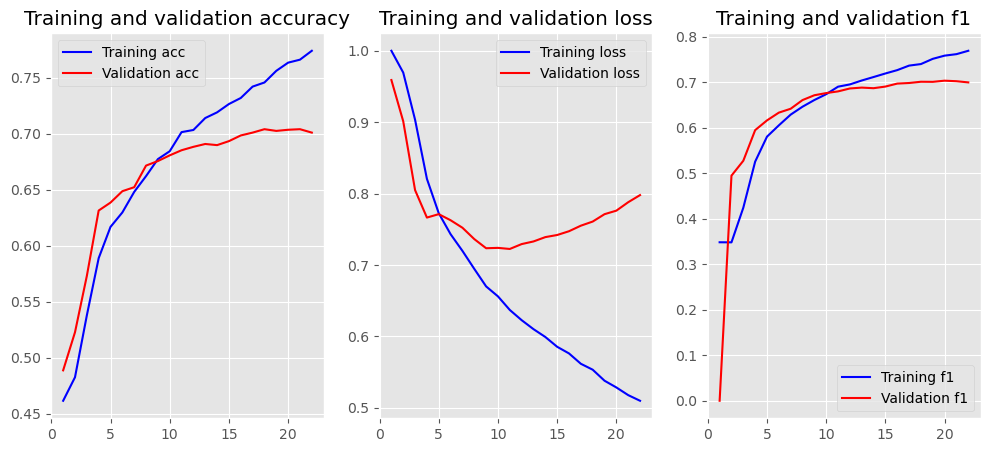

In [56]:
es = EarlyStopping(monitor='val_f1', mode='max', verbose=1, patience=2)

history3 = model3.fit(XY_train,
          batch_size=32,
          epochs=25,
          verbose=1,
          validation_data=(XY_validation), 
          callbacks=[es])

score, accuracy, f1Score = model3.evaluate(XY_validation, batch_size=32, verbose=2)

plot_history(history3)

In [57]:
m3preds = model3.predict(X_test)
test["globalAvgPoolSigmoidPrediction"] = np.argmax(m3preds, axis=-1)

62/62 [==============================] - 0s 2ms/step


#### GlobalAveragePool (relu)

In [58]:
model3b = Sequential()
model3b.add(Embedding(vocabLengthTV, 128))
model3b.add(GlobalAveragePooling1D())
model3b.add(Dense(128, activation='relu'))
model3b.add(Dropout(0.2))
model3b.add(Dense(3, activation='softmax'))

model3b.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1])

print(model3b.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         2864768   
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,881,667
Trainable params: 2,881,667
Non-trainable params: 0
____________________________________________

Epoch 1/10
493/493 [==============================] - 15s 29ms/step - loss: 0.9726 - accuracy: 0.4867 - f1: 0.2146 - val_loss: 0.9451 - val_accuracy: 0.4914 - val_f1: 0.0029
Epoch 2/10
493/493 [==============================] - 13s 27ms/step - loss: 0.8912 - accuracy: 0.5467 - f1: 0.3919 - val_loss: 0.7640 - val_accuracy: 0.6289 - val_f1: 0.5559
Epoch 3/10
493/493 [==============================] - 13s 27ms/step - loss: 0.7596 - accuracy: 0.6258 - f1: 0.5840 - val_loss: 0.6975 - val_accuracy: 0.6629 - val_f1: 0.6465
Epoch 4/10
493/493 [==============================] - 13s 27ms/step - loss: 0.6868 - accuracy: 0.6743 - f1: 0.6556 - val_loss: 0.6625 - val_accuracy: 0.6873 - val_f1: 0.6868
Epoch 5/10
493/493 [==============================] - 13s 27ms/step - loss: 0.6412 - accuracy: 0.6999 - f1: 0.6874 - val_loss: 0.6542 - val_accuracy: 0.6975 - val_f1: 0.6940
Epoch 6/10
493/493 [==============================] - 14s 27ms/step - loss: 0.6071 - accuracy: 0.7194 - f1: 0.7131 - val_loss: 0.6

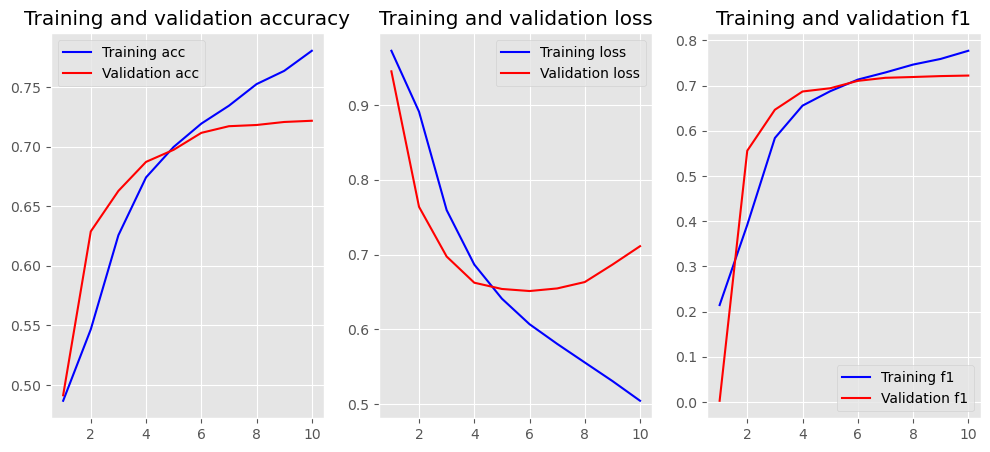

In [59]:
es = EarlyStopping(monitor='val_f1', mode='max', verbose=1, patience=2)

history3b = model3b.fit(XY_train,
          batch_size=32,
          epochs=10,
          verbose=1,
          validation_data=(XY_validation), 
          callbacks=[es])

score, accuracy, f1Score = model3b.evaluate(XY_validation, batch_size=32, verbose=2)

plot_history(history3b)

In [60]:
m3bpreds = model3b.predict(X_test)
test["globalAvgPoolReluPrediction"] = np.argmax(m3bpreds, axis=-1)

62/62 [==============================] - 0s 2ms/step


#### GlobalMaxPool (sigmoid)

In [61]:
model4 = Sequential()
model4.add(Embedding(vocabLengthTV, 128))
model4.add(GlobalMaxPooling1D())
model4.add(Dense(128, activation='sigmoid'))
model4.add(Dropout(0.2))
model4.add(Dense(3, activation='softmax'))

model4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1])

print(model4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 128)         2864768   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,881,667
Trainable params: 2,881,667
Non-trainable params: 0
____________________________________________

Epoch 1/10
493/493 [==============================] - 16s 32ms/step - loss: 0.8789 - accuracy: 0.5479 - f1: 0.4771 - val_loss: 0.6904 - val_accuracy: 0.6645 - val_f1: 0.6430
Epoch 2/10
493/493 [==============================] - 15s 31ms/step - loss: 0.6484 - accuracy: 0.6982 - f1: 0.6893 - val_loss: 0.6433 - val_accuracy: 0.6980 - val_f1: 0.6900
Epoch 3/10
493/493 [==============================] - 15s 31ms/step - loss: 0.5523 - accuracy: 0.7525 - f1: 0.7493 - val_loss: 0.6412 - val_accuracy: 0.7041 - val_f1: 0.7013
Epoch 4/10
493/493 [==============================] - 16s 32ms/step - loss: 0.4597 - accuracy: 0.8056 - f1: 0.8030 - val_loss: 0.6708 - val_accuracy: 0.7036 - val_f1: 0.7008
Epoch 5/10
493/493 [==============================] - 16s 31ms/step - loss: 0.3665 - accuracy: 0.8523 - f1: 0.8516 - val_loss: 0.7232 - val_accuracy: 0.6990 - val_f1: 0.6963
Epoch 5: early stopping
62/62 - 0s - loss: 0.7232 - accuracy: 0.6990 - f1: 0.6963 - 186ms/epoch - 3ms/step


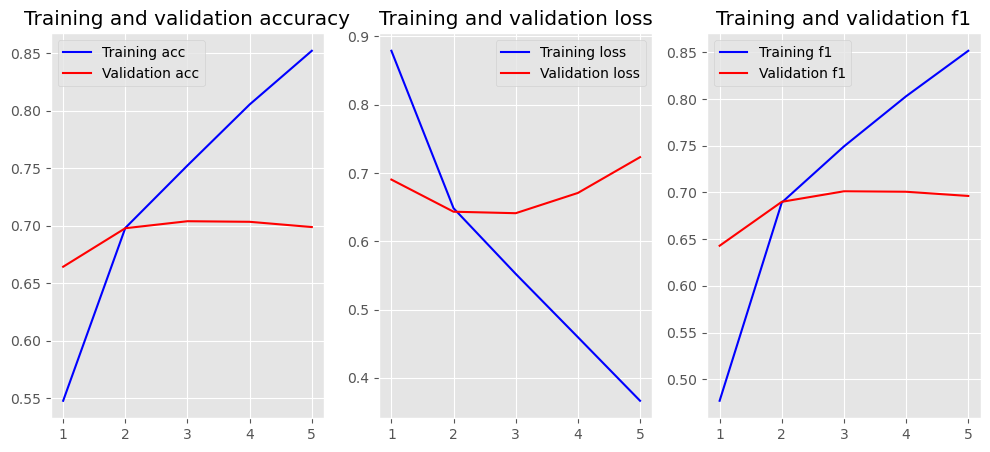

In [62]:
es = EarlyStopping(monitor='val_f1', mode='max', verbose=1, patience=2)

history4 = model4.fit(XY_train,
          batch_size=32,
          epochs=10,
          verbose=1,
          validation_data=(XY_validation), 
          callbacks=[es])

score, accuracy, f1Score = model4.evaluate(XY_validation, batch_size=32, verbose=2)

plot_history(history4)

In [63]:
m4preds = model4.predict(X_test)
test["globalMaxPoolSigmoidPrediction"] = np.argmax(m4preds, axis=-1)

62/62 [==============================] - 0s 2ms/step


#### GlobalMaxPool (relu)

In [64]:
model4b = Sequential()
model4b.add(Embedding(vocabLengthTV, 128))
model4b.add(GlobalMaxPooling1D())
model4b.add(Dense(128, activation='relu'))
model4b.add(Dropout(0.2))
model4b.add(Dense(3, activation='softmax'))

model4b.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1])

print(model4b.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 128)         2864768   
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,881,667
Trainable params: 2,881,667
Non-trainable params: 0
____________________________________________

Epoch 1/10
493/493 [==============================] - 18s 34ms/step - loss: 0.8168 - accuracy: 0.5924 - f1: 0.4803 - val_loss: 0.6692 - val_accuracy: 0.6797 - val_f1: 0.6683
Epoch 2/10
493/493 [==============================] - 16s 32ms/step - loss: 0.6013 - accuracy: 0.7244 - f1: 0.7161 - val_loss: 0.6493 - val_accuracy: 0.6975 - val_f1: 0.6927
Epoch 3/10
493/493 [==============================] - 16s 33ms/step - loss: 0.4833 - accuracy: 0.7933 - f1: 0.7918 - val_loss: 0.6785 - val_accuracy: 0.6964 - val_f1: 0.6907
Epoch 4/10
493/493 [==============================] - 16s 32ms/step - loss: 0.3590 - accuracy: 0.8574 - f1: 0.8558 - val_loss: 0.7641 - val_accuracy: 0.6792 - val_f1: 0.6778
Epoch 4: early stopping
62/62 - 0s - loss: 0.7641 - accuracy: 0.6792 - f1: 0.6778 - 176ms/epoch - 3ms/step


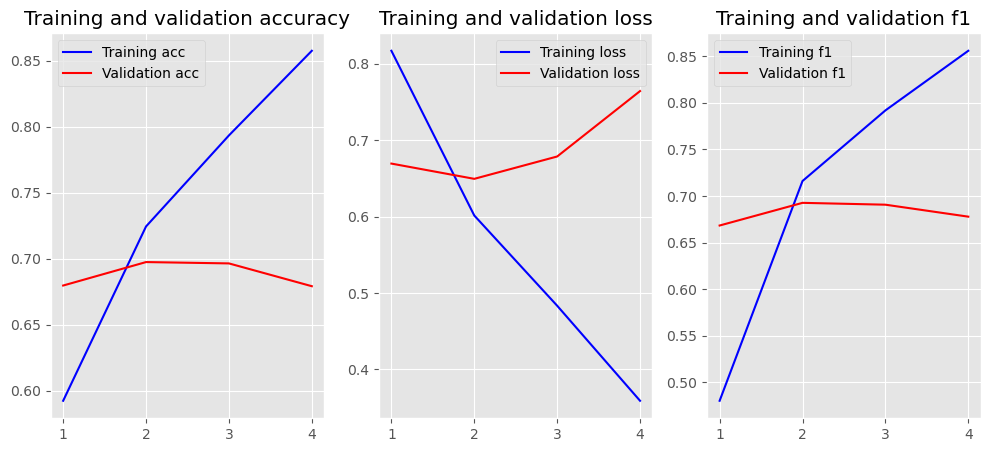

In [65]:
es = EarlyStopping(monitor='val_f1', mode='max', verbose=1, patience=2)

history4b = model4b.fit(XY_train,
          batch_size=32,
          epochs=10,
          verbose=1,
          validation_data=(XY_validation), 
          callbacks=[es])

score, accuracy, f1Score = model4b.evaluate(XY_validation, batch_size=32, verbose=2)

plot_history(history4b)

In [66]:
m4bpreds = model4b.predict(X_test)
test["globalMaxPoolReluPrediction"] = np.argmax(m4bpreds, axis=-1)

62/62 [==============================] - 0s 3ms/step


# Evaluation

In [ ]:
test.drop(['id', 'dateAdded', 'dateUpdated', 'address', 'categories',
       'primaryCategories', 'city', 'country', 'keys', 'latitude', 'longitude',
       'commonPositiveCount', 'commonNeutralCount', 'commonNegativeCount',
       'name', 'postalCode', 'province', 'reviews.date', 'reviews.dateSeen',
       'reviews.rating', 'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username',
       'sourceURLs', 'websites', 'language', 'reviews.clean_text',
       'userCity_upper', 'userProvince_upper', 'is_state', 'user_country'], axis=1, inplace=True)

In [133]:
categories = ['ratingCategory', 'naiveBayesPrediction', 'svmPrediction',
              'logregPrediction', 'lgbmPrediction', 'adaboostPrediction',
              'gradboostPrediction', 'cnnPrediction',
              'globalAvgPoolSigmoidPrediction', 'globalAvgPoolReluPrediction',
              'globalMaxPoolSigmoidPrediction', 'globalMaxPoolReluPrediction']

for cat in categories:
    test[cat] = test[cat].astype("category")

test.dtypes

ratingCategory                    category
naiveBayesPrediction              category
svmPrediction                     category
logregPrediction                  category
lgbmPrediction                    category
adaboostPrediction                category
gradboostPrediction               category
cnnPrediction                     category
globalAvgPoolSigmoidPrediction    category
globalAvgPoolReluPrediction       category
globalMaxPoolSigmoidPrediction    category
globalMaxPoolReluPrediction       category
VADERPrediction                    float64
aggregatedPreds                    float64
dtype: object

In [ ]:
test.loc[(test["negValueVADER"] > test["neuValueVADER"]) & (test["negValueVADER"] > test["posValueVADER"]), "VADERPrediction"] = 0
test.loc[(test["neuValueVADER"] >= test["negValueVADER"]) & (test["neuValueVADER"] > test["posValueVADER"]), "VADERPrediction"] = 1
test.loc[(test["posValueVADER"] >= test["negValueVADER"]) & (test["posValueVADER"] >= test["neuValueVADER"]), "VADERPrediction"] = 2

test.drop(['negValueVADER', 'neuValueVADER', 'posValueVADER', 'compoundValueVADER'], axis=1, inplace=True)

In [191]:
performance_tracker = pd.DataFrame(columns=["Accuracy", "F1 Negative Category", "F1 Neutral Category", "F1 Positive Category", "Weighted Score"])

In [192]:
for col in test.columns:
    if col == "ratingCategory":
        continue
    f1Cat = f1_score(test["ratingCategory"], test[col], average=None)
    performance_tracker.loc[col] = [
        accuracy_score(test["ratingCategory"], test[col]), 
        f1Cat[0], 
        f1Cat[1], 
        f1Cat[2], 
        f1_score(test["ratingCategory"], test[col], average="weighted")]
    
performance_tracker

,Accuracy,F1 Negative Category,F1 Neutral Category,F1 Positive Category,Weighted Score
naiveBayesPrediction,0.630644,0.025974,0.538614,0.757741,0.582595
svmPrediction,0.699645,0.627737,0.627554,0.768620,0.694064
logregPrediction,0.709792,0.668281,0.649268,0.767109,0.707010
lgbmPrediction,0.691020,0.661939,0.616393,0.754263,0.686645
adaboostPrediction,0.639269,0.566845,0.575259,0.707836,0.636774
gradboostPrediction,0.691527,0.625323,0.627401,0.754641,0.687133
cnnPrediction,0.677321,0.677060,0.577474,0.749507,0.670079
globalAvgPoolSigmoidPrediction,0.709792,0.686316,0.634858,0.773238,0.706034
globalAvgPoolReluPrediction,0.727549,0.700665,0.688955,0.769824,0.728426
globalMaxPoolSigmoidPrediction,0.706240,0.694143,0.636893,0.764463,0.703644


### Aggregating Predictions
We check to see if aggregating predictions from different models have a positive effect on the weighted score.
We will use all models except the lowest performing 3 models (NB, ADA, VADER) to do so.

In [193]:
test["aggregatedPreds"] = test[test.columns[~test.columns.isin(["ratingCategory", "naiveBayesPrediction", "adaboostPrediction", "VADERPrediction"])]].sum(axis=1) / 9
test["aggregatedPreds"] = test["aggregatedPreds"].round()

In [194]:
f1Cat = f1_score(test["ratingCategory"], test["aggregatedPreds"], average=None)
performance_tracker.loc["Aggregated Predictions"] = [
    accuracy_score(test["ratingCategory"], test["aggregatedPreds"]), 
    f1Cat[0], 
    f1Cat[1], 
    f1Cat[2], 
    f1_score(test["ratingCategory"], test["aggregatedPreds"], average="weighted")]

In [195]:
performance_tracker

,Accuracy,F1 Negative Category,F1 Neutral Category,F1 Positive Category,Weighted Score
naiveBayesPrediction,0.630644,0.025974,0.538614,0.757741,0.582595
svmPrediction,0.699645,0.627737,0.627554,0.768620,0.694064
logregPrediction,0.709792,0.668281,0.649268,0.767109,0.707010
lgbmPrediction,0.691020,0.661939,0.616393,0.754263,0.686645
adaboostPrediction,0.639269,0.566845,0.575259,0.707836,0.636774
gradboostPrediction,0.691527,0.625323,0.627401,0.754641,0.687133
cnnPrediction,0.677321,0.677060,0.577474,0.749507,0.670079
globalAvgPoolSigmoidPrediction,0.709792,0.686316,0.634858,0.773238,0.706034
globalAvgPoolReluPrediction,0.727549,0.700665,0.688955,0.769824,0.728426
globalMaxPoolSigmoidPrediction,0.706240,0.694143,0.636893,0.764463,0.703644


As `globalAvgPoolReluPrediction` still provides the highest weighted score, we will use that model as our predictor.

# Output File

In [196]:
test.to_csv(r'outputTest.csv', index=False)

In [197]:
print(test.isna().any())

ratingCategory                    False
naiveBayesPrediction              False
svmPrediction                     False
logregPrediction                  False
lgbmPrediction                    False
adaboostPrediction                False
gradboostPrediction               False
cnnPrediction                     False
globalAvgPoolSigmoidPrediction    False
globalAvgPoolReluPrediction       False
globalMaxPoolSigmoidPrediction    False
globalMaxPoolReluPrediction       False
VADERPrediction                   False
aggregatedPreds                   False
dtype: bool
